<hr>
<b> Set up modules (standard and mine) </br>
<hr>

In [27]:
### Import Standard Packages ###
import matplotlib.pyplot as mp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import numpy as np
import metpy.calc as mpc
import metpy.constants as mconst
import xarray as xr
import scipy as spy
import pandas as pd
import datetime as dt
import cartopy


### To Import My Functions ###
import scam_func as mypy
import importlib


#### CONSTANTS #####
r_gas = mconst.dry_air_gas_constant.magnitude   # Specific gas constant for dry air
cp_air = mconst.dry_air_spec_heat_press.magnitude # Specific heat for dry air
Lv = mconst.water_heat_vaporization.magnitude       # Latent heat of vaporization

r_cp = r_gas/cp_air    # r/cp
grav = mconst.earth_gravity.magnitude       # Gravity ave.
p0 = mconst.pot_temp_ref_press.magnitude

#%xmode Plain   ## Fortran-like error tracebacks (doesn't seem to work though)

<hr>
<b> Add Experiment Set </b>
<hr>

In [28]:

#### SCRIPT TO READ IN SCAM OUTPUT AND MAKE SOME PLOTS ####
###### IOP file info. ######

#xr.show_versions()




## Vertical resolution ##
#scam_file_nums = ['100a','100','100b','100c']
#scam_file_nums = ['101a','101','101b','101c','101d'] # 'a'=L16, ''=L32
#scam_run_names = ['L16','L32','L64','L128','L256']

#scam_file_nums = ['102a','102','102b','102c'] # 'a'=L15, ''=L30
#scam_run_names = ['L15','L30','L60','L120']


#scam_file_nums = ['101','102'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6','CAM5']


#scam_file_nums = ['101def','102def'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6 default','CAM5 default']

#scam_file_nums = ['101','101def'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6 2 min','CAM6']

#scam_file_nums = ['102','102def'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM5 2 min','CAM5']

#scam_file_nums = ['101','102'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6 2 min','CAM5 2 min']



#scam_file_nums = ['101d','201d','202d'] # 'a'=L16, ''=L32
#scam_run_names = ['gamma_coef=0.308','gamma_coef=0.285','gamma_coef=0.345']

### WITH LES ###

#scam_file_nums = np.array(['101d','203d','204d','LES']) # 'a'=L16, ''=L32
#scam_run_names = ['clubb_c_k10=0.5','clubb_c_k10=0.3','clubb_c_k10','LES']

#scam_file_nums = ['101a','101','101b','101c','101d']# 'a'=L16, ''=L32
#scam_run_names = ['L16','L32','L64','L128','L256']

#scam_file_nums = ['106def','106d','LES'] # ''=L16, ''=L32
#scam_run_names = ['CAM6-L32-20min','CAM6-L256-2min','NCAR']

#scam_file_nums = ['106d','106d.uv','106d.no_lsf'] # ''=L16, ''=L32
#scam_run_names = ['CAM6-L256','CAM6-L256.uv','106d.uv.no_lts']

#scam_file_nums = ['106','106.norad','LES'] # ''=L16, ''=L32
#scam_run_names = ['CAM6','CAM6-NoRad','NCAR']

scam_file_nums = ['106d','106d.norad','LES'] # ''=L16, ''=L32
scam_run_names = ['CAM6-L256','CAM6-L256-NoRad','NCAR']


#scam_file_nums = ['106d','110d','112d'] # ''=L16, ''=L32
#scam_run_names = ['CAM6-L256-2min','lmin_scale = 5.','C1=0.01']

#scam_file_nums = ['106d','112d','113d'] # ''=L16, ''=L32
#scam_run_names = ['CAM6-L256-2min','C1=001','C15=0.4']

#scam_file_nums = ['106def','106d'] # ''=L16, ''=L32
#scam_run_names = ['CAM6','CAM6-L256-2min']

#scam_file_nums = ['106d','107d','108d'] # ''=L16, ''=L32
#scam_run_names = ['gamma_coef=0.308','gamma_coef=0.285','gamma_coef=0.345']

#scam_file_nums = ['106c','106c.cam5','LES'] # ''=L16, ''=L32
#scam_run_names = ['CAM6-L128','CAM5-L120','NCAR']

#scam_file_nums = ['106a','106','106b','106c','106d','LES'] # ''=L16, ''=L32
#scam_run_names = ['CAM6-L16','CAM6-L32','CAM6-L64','CAM6-L128','CAM6-L256','NCAR']



######### PRE/SUF-FIXING THE FILENAMES ##########

scam_file_pre = "FSCAM.T42_T42.SAS."
scam_file_suf = ".cam.h0.2013-06-10-39600" # most recent IC data (>=21)

#scam_file_suf = ".cam.h0.2013-06-10-43200" # Older IOP IC data (per-21)


#### LES model selections ####

les_files_in = {}
les_files_in['NCAR'] = "patton_sas_stats.nc"


########## BASE DIR ############

dir_main = '/Users/rneale/Documents/NCAR/PBL/PBL_py_data/'




<hr>
<b> Diagnostic Field Selections </b><br>
<i> List of variables for each plot type</i>
<hr>

In [29]:
#### PLOTTING ####

### ### ### ### 
### 1D TS ### 
### ### ### ### 
#pvars_ts1d = np.array(['PBLH','TS','LHFLX','SHFLX','PRECC','PRECL','FLNS']) # D profile timeseries plots
#pvars_ts2d = ['DTV','VD01','DCQ','Q','T','TH','THL']
pvars_ts1d = np.array(['SHFLX','LHFLX','PBLH','PBLH_DQ'])




### ### ### ### 
### 2D TS ###
### ### ### ### 
                       ## WPSKEW is WP3_CLUBB/WP2_CLUBB**3/2
#pvars_ts2d = ['T','Q','RELHUM','TH','THL','CLOUD','ZMDQ','ZMDT', 
#            'STEND_CLUBB','RVMTEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','WP3_CLUBB','THLP2_CLUBB','WP2_CLUBB'] # 2D profile timeseries plots
#pvars_ts2d = ['WPRTP_CLUBB','Q','TH']
#pvars_ts2d = ['DTV','VD01','DCQ','Q','T','TH','THL']
pvars_ts2d = ['THV','TH','Q','WP2_CLUBB','WP3_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','RTP2_CLUBB']



### ### ### ### ### 
### 1D SNAPSHOT ###
### ### ### ### ### 

#pvars_ts2d = ['T','Q','RELHUM','TH','THL','CLOUD','ZMDQ','ZMDT','DTCOND','DCQ']

#pvars_ts2d = ['STEND_CLUBB','RVMTEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','WP2_CLUBB','WP3_CLUBB'] 
    
#pvars_snap = ['STEND_CLUBB','RVMTEND_CLUBB','TH','THL','Q','RVMTEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','WP2_CLUBB','WP3_CLUBB']  # Snapshot plotting vars
#pvars_snap = ['T','Q','RELHUM','TH','THL','CLOUD','ZMDQ','ZMDT','DTCOND','DCQ']
#pvars_snap = ['TH','THL','Q','RELHUM','DTV','DCQ','STEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','WP2_CLUBB','WP3_CLUBB']
pvars_snap = ['TH','Q','WP2_CLUBB','WP3_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','RTP2_CLUBB']

tsnaps = np.array([6.,8.,10.,12.,14.,16.,18.])     # Time of snapshots (local time)

### ### ### ### ### 
### ANIMATIONS ###  # Not used yet
### ### ### ### ### 
    
pvars_anim = np.array(('Q'))






<hr>
<b> File and Array Setups </b>
<hr>

In [30]:
####### DERIVED VARS #######

#scam_files_in = scam_file_pre+scam_file_nums+scam_file_suf 
scam_fig_stub=dir_main+'png/'+'_'.join(scam_file_nums)

zoffset = 6.  # Offset for Z time.


### Bundle these array for pasing to functions ###
run_info = {}
run_info['1dvars'] = pvars_ts1d
run_info['2dvars'] = pvars_ts2d
run_info['snapvars'] = pvars_snap

####### GRAPHICS ########
#mp.interactive(True)
#%matplotlib qt
#%matplotlib inline






### Construct filenames ### 

scam_files_in = np.empty_like(scam_file_nums)
scam_file_nums = np.array(scam_file_nums) 
scam_run_names = np.array(scam_run_names) 


# Standard SCAM
scam_files_in = [dir_main+'history/'+scam_file_pre+x+scam_file_suf+'.nc' for x in scam_file_nums] 

# SCAM in SAS-LES format
ii = [ix for ix, x in enumerate(scam_file_nums) if x == 'LES']# Change to LES-SAS-format file if needed 
for i in ii: scam_files_in[i] = dir_main+'history/'+scam_file_pre+scam_file_nums[0]+scam_file_suf+'_SAS_format.nc' 

# LES in SAS-LES format
scam_files_in = np.where(scam_run_names == 'NCAR', dir_main+'LES/'+les_files_in['NCAR'],scam_files_in) # Change to LES file if needed
#scam_files_in = np.where(scam_run_names == 'FAST_EDDY','LES/'+les_files_in['FAST_EDDY'],scam_files_in) # Change to LES file if needed

print(scam_files_in)

### Bundle run info ###

run_info['Run Name']   = scam_run_names
run_info['File Num']   = scam_file_nums
run_info['File Name']  = scam_files_in
run_info['zoffset']    = zoffset
run_info['Stub Figs']  = scam_fig_stub
run_info['Snap Times']  = tsnaps

#df_rinfo = pd.DataFrame(rinfo)
#df_rinfo.style.set_properties(**{'background-color': 'white','color': 'yellow'})
#df_rinfo.style.apply({'background-color': 'white'})

['/Users/rneale/Documents/NCAR/PBL/PBL_py_data/history/FSCAM.T42_T42.SAS.106d.cam.h0.2013-06-10-39600.nc'
 '/Users/rneale/Documents/NCAR/PBL/PBL_py_data/history/FSCAM.T42_T42.SAS.106d.norad.cam.h0.2013-06-10-39600.nc'
 '/Users/rneale/Documents/NCAR/PBL/PBL_py_data/LES/patton_sas_stats.nc']


<b> Plot type selection </b>

+++ IMPORTING MY FUNCTIONS +++
---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  THV  -  Virtual Potential Temperature  -- cmin/cmax -->  295.0 305.0
Case =  106d Range= 298.28233744982776 1513.949426645471
Case =  106d.norad Range= 298.7276625061088 1488.759099807137


/Users/rneale/Documents/NCAR/python/python-scripts/PBL/scam_func.py:578: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  mp.colorbar(plt0, extend='both',cax=fig1.add_axes([0.92,  0.13, 0.02, 0.76]))


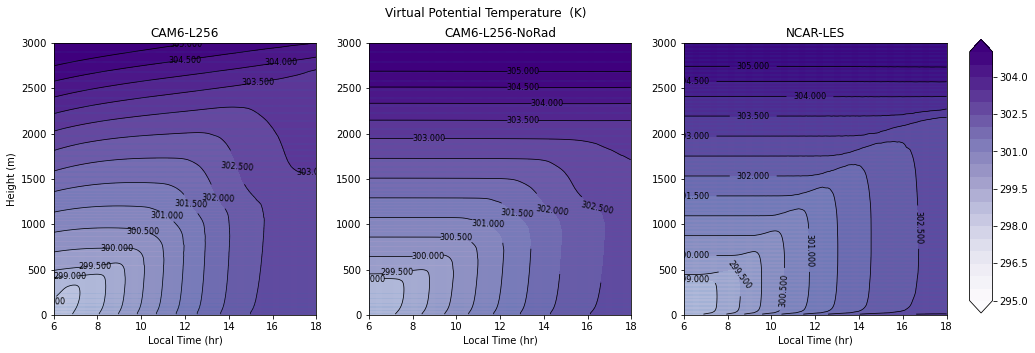

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  TH  -  Potential Temperature  -- cmin/cmax -->  295.0 305.0
Case =  106d Range= 296.15068718174587 1513.94689997399
Case =  106d.norad Range= 296.5929350709043 1488.7566151764793


/Users/rneale/Documents/NCAR/python/python-scripts/PBL/scam_func.py:578: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  mp.colorbar(plt0, extend='both',cax=fig1.add_axes([0.92,  0.13, 0.02, 0.76]))


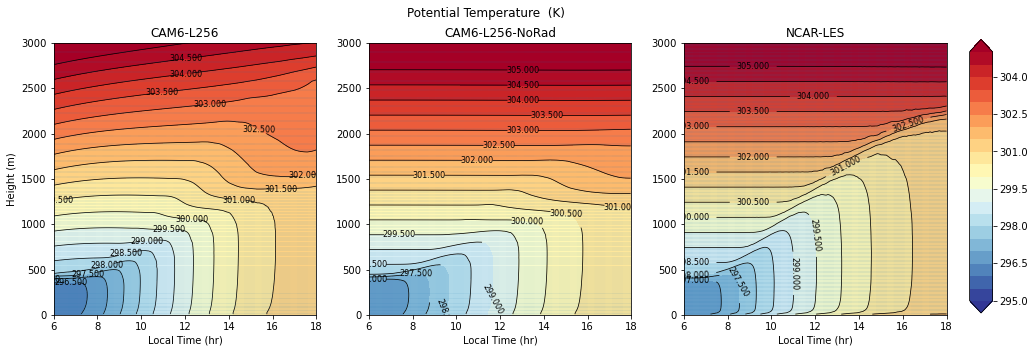

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  Q  -  Specific humidity  -- cmin/cmax -->  1.0 12.0
Case =  106d Range= 5.1746676e-11 0.011813239
Case =  106d.norad Range= 5.1746678e-08 11.799983


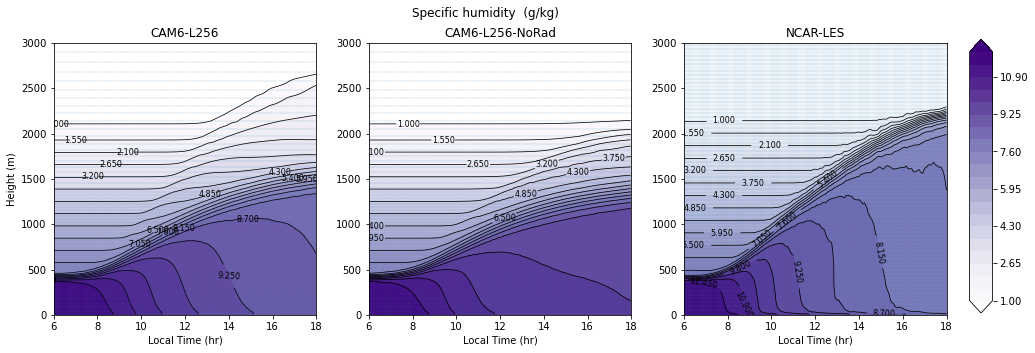

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  WP2_CLUBB  -  Vertical Velocity Variance  -- cmin/cmax -->  0.0 2.0
Case =  106d Range= 0.0004 0.9029179
Case =  106d.norad Range= 0.0004 0.77523136


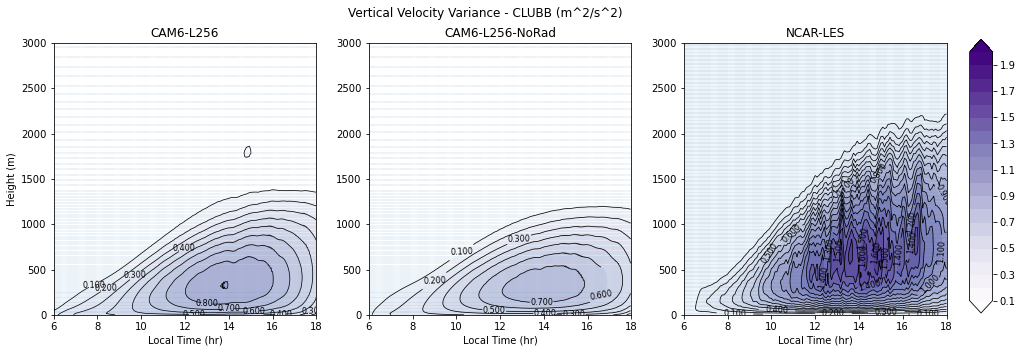

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  WP3_CLUBB  -  Third Moment Vertical Velocity  -- cmin/cmax -->  0.0 0.5
Case =  106d Range= -0.021550564 0.16489844
Case =  106d.norad Range= -0.01879344 0.12422784


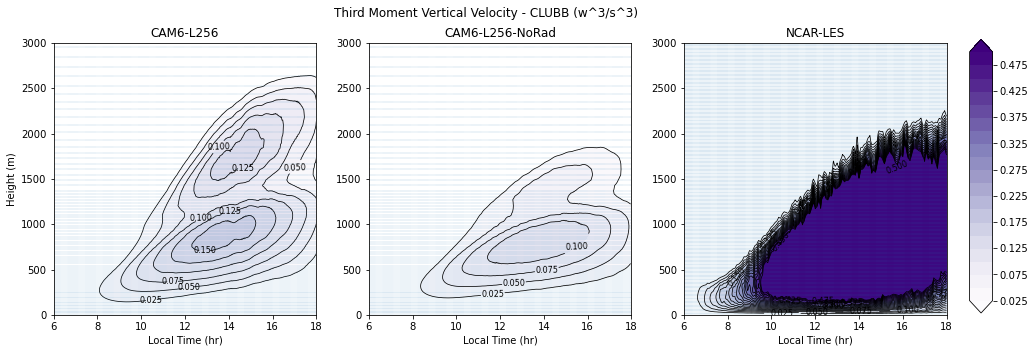

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  WPTHLP_CLUBB  -  Heat Flux  -- cmin/cmax -->  -100.0 100.0
Case =  106d Range= -19.7061 101.15477
Case =  106d.norad Range= -17.73765 101.17299


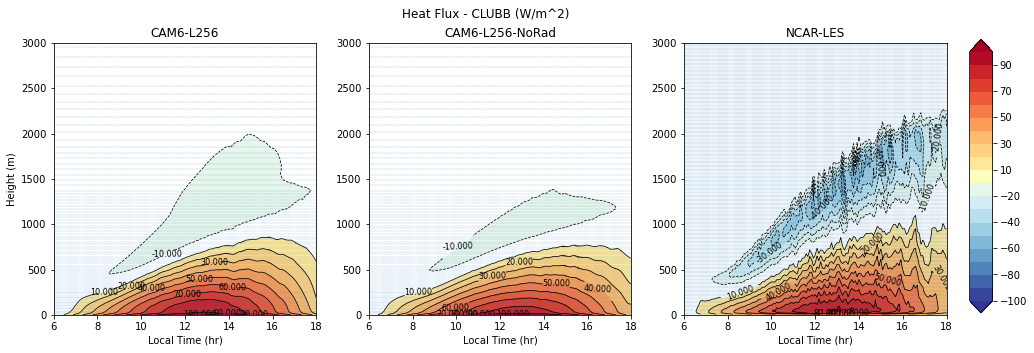

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  WPRTP_CLUBB  -  Moisture Flux  -- cmin/cmax -->  -0.0 600.0
Case =  106d Range= -0.040225666 446.16425
Case =  106d.norad Range= -0.042551696 384.65756


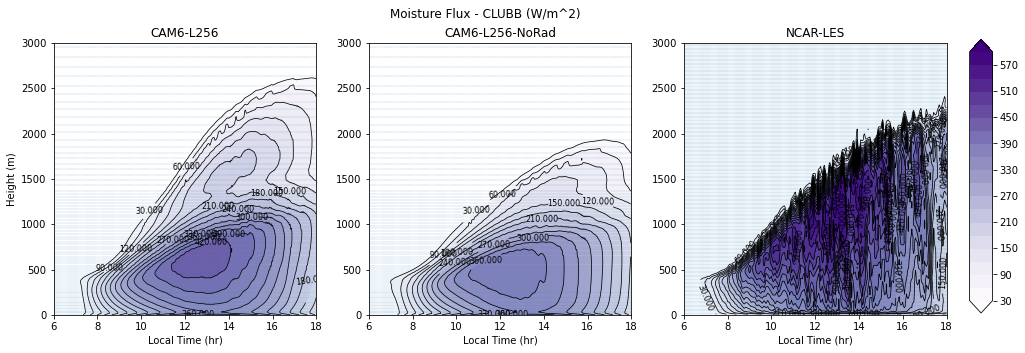

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  THLP2_CLUBB  -  Temperature Variance  -- cmin/cmax -->  0.0 0.05
Case =  106d Range= 1e-04 0.028480137
Case =  106d.norad Range= 1e-04 0.03411152


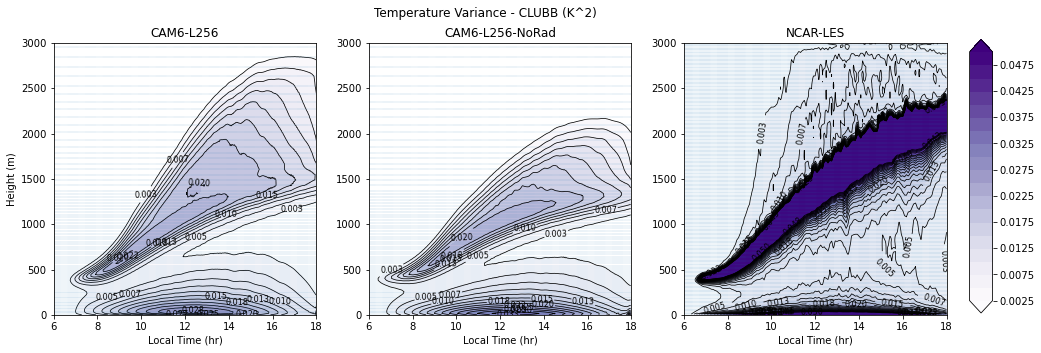

---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  
 -  RTP2_CLUBB  -  Moisture Variance  -- cmin/cmax -->  0.0 2.5
Case =  106d Range= 5e-11 0.51289165
Case =  106d.norad Range= 1e-10 0.5143965


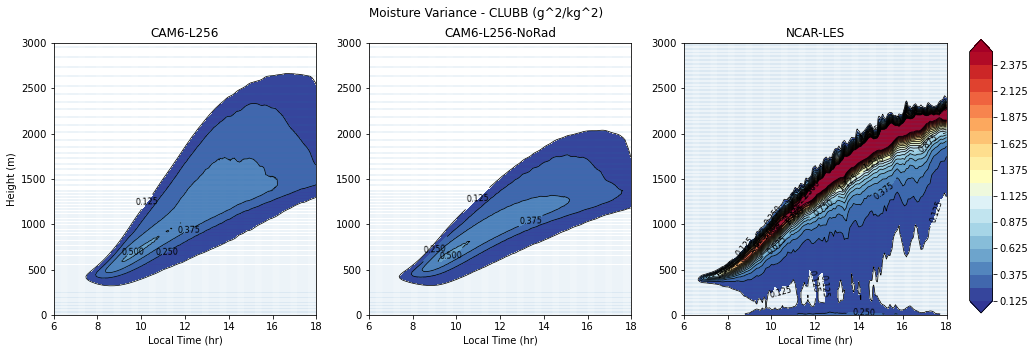

In [31]:
###### Plotting ##########
importlib.reload(mypy) # Required because I am constantly editing scam_func.py
#dir(mypy)

###### PLOTS ######

#mypy.plot1d_ts_scam(run_info)   # 1D time series plots
mypy.plot2d_ts_scam(run_info)   # 2D time series plots
#mypy.plot1d_snap_scam(run_info)   # 1D snapshot plots
#mypy.plot1d_anim_scam(run_info) # 2D animation  plots
